# EMG Data Exploration

In this notebook we explore the sEMG dataset for different hand gestures. We perform the following steps:

* Preprocess and clean up our dataset
* Leverage signal processing to smooth out the dataset
* Perform a variety of classification techniques

In [1]:
import random

import numpy as np
import pandas as pd

import scipy.io
import scipy
from scipy import signal

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.cluster import KMeans

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.manifold import Isomap

In [19]:
#Workflow Pre-process -> Transform -> Classify

#Pre-processing
    #Absolute value (all after use Absolute value)
    #Smooth (multiply hyper-parameters) 

#Transform
    #As is
    #PCA
    #Isomap

#Classify
    #SVM (Linear)
    #KMeans
    #GM
    #Naive-Bayes
    #Logistic Regression
    #Neural Net

In [2]:
""" Define schema of datasets
"""

DATABASE = {
    'Database 1': ['female_1',
                  'female_2',
                  'female_3',
                  'male_1',
                  'male_2'],
    'Database 2': ['male_day_1',
                  'male_day_2',
                  'male_day_3']
}

COLUMNS = ['cyl_ch1', 
            'cyl_ch2', 
            'hook_ch1', 
            'hook_ch2', 
            'tip_ch1', 
            'tip_ch2', 
            'palm_ch1', 
            'palm_ch2', 
            'spher_ch1', 
            'spher_ch2', 
            'lat_ch1', 
            'lat_ch2']

LABELS = [
    'Spherical',
    'Tip',
    'Palmar',
    'Lateral',
    'Cylindrical',
    'Hook'
]

COL_MAPPINGS = {
            'cyl_ch1': 'Cylindrical', 
            'cyl_ch2': 'Cylindrical', 
            'hook_ch1': 'Hook', 
            'hook_ch2': 'Hook', 
            'tip_ch1': 'Tip', 
            'tip_ch2': 'Tip', 
            'palm_ch1': 'Palmar', 
            'palm_ch2': 'Palmar', 
            'spher_ch1': 'Spherical', 
            'spher_ch2': 'Spherical', 
            'lat_ch1': 'Lateral', 
            'lat_ch2': 'Lateral'
}

In [3]:
""" Preprocess and standardize dataset into a single dataframe table
"""

DB_NAME = 'Database 1'
dfs = []
for fname in DATABASE[DB_NAME]: 
    tmp_data = scipy.io.loadmat(f'./data/{DB_NAME}/{fname}')
    tmp_data = {k:v for k,v in tmp_data.items() if k in COLUMNS}
    for c in COLUMNS:
        tmp_dfx = pd.DataFrame(tmp_data[c])
        tmp_dfx['identifier'] = fname
        tmp_dfx['label'] = COL_MAPPINGS[c]
        dfs.append(pd.DataFrame(tmp_dfx))

        
dataset_ = pd.concat(dfs)

#combine coupled readouts
new_dfs = []
for lab in LABELS:
    new_temp = dataset_[dataset_['label'] == lab].values
    new_temp_comb = pd.DataFrame(np.concatenate((new_temp[:150,:3000],new_temp[150:,:3002]),axis=1))
    new_dfs.append(new_temp_comb)

dataset = pd.concat(new_dfs)
dataset.rename(columns={6001:'label', 6000:'identifier'}, inplace=True)
dataset.head()

df_features = dataset.iloc[:,:6000].copy()
df_labels = dataset.iloc[:, 6001]

In [4]:

#Preprosess
def abs_val_filter(data):
    return abs(data.copy())


def butterworth_low_pass_filter(data, 
                                frequency=500, 
                                lp_filter=5,
                                order=4):

    lp_filter = lp_filter/(frequency/2)

    # Create a lowpass butterworth signal 
    B, A = scipy.signal.butter(order, 
                               lp_filter, 
                               btype='lowpass')

    # Apply the lowpass signal filter to EMG data
    smooth_emg = scipy.signal.filtfilt(B, 
                                       A, 
                                       data)
    return smooth_emg


def holt_smoothing(data,
                  s_level = 0.5,
                  s_slope = 0.1):
    smoothed = []
    for i in data:
        smoothed.append(Holt(i).fit(smoothing_level=s_level, smoothing_slope=s_slope).fittedvalues[:])
    return np.array(smoothed)
    

C:\Users\hayde\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


 ...]

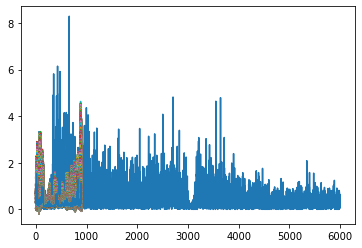

In [5]:

df_features = abs_val_filter(df_features)
holt_emg_df = holt_smoothing(df_features.to_numpy(), s_level = 0.03, s_slope = 0.02)



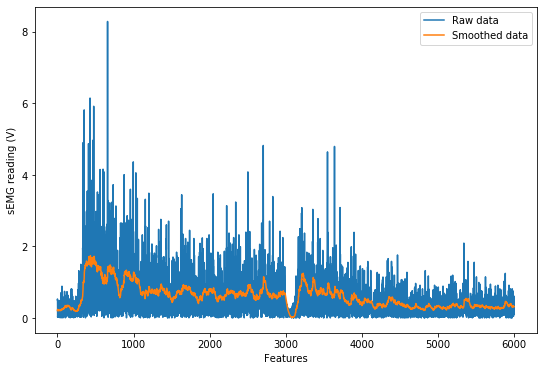

In [14]:
fig = plt.figure(figsize=(9,6))
plt.plot(df_features.to_numpy()[0], label='Raw data')
plt.plot(holt_emg_df[0], label='Smoothed data')
plt.legend(loc="upper right")
plt.xlabel("Features")
plt.ylabel("sEMG reading (V)")
plt.show()

In [16]:
#as is DF
df_as_is = abs_val_filter(df_features)

#smoothed
df_filter = butterworth_low_pass_filter(df_as_is.to_numpy(), frequency=5000, lp_filter=25, order=5)

In [17]:
#smoothed
df_smoothed = holt_smoothing(df_as_is.to_numpy(), s_level = 0.03, s_slope = 0.02)
#df_features.to_numpy()[0]

C:\Users\hayde\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [19]:
#PCA Transform
n = 2
pca = PCA(n_components=n).fit(df_smoothed.T)
df_pca = pca.components_.T

In [48]:
label_dict = {
    'Spherical':1,
    'Tip':2,
    'Palmar':3,
    'Lateral':4,
    'Cylindrical':5,
    'Hook':6}

col = [label_dict[i] for i in df_labels.to_list()]

In [54]:
#Isomap Transform
iso = Isomap(n_components=3)
df_iso = iso.fit_transform(df_smoothed)

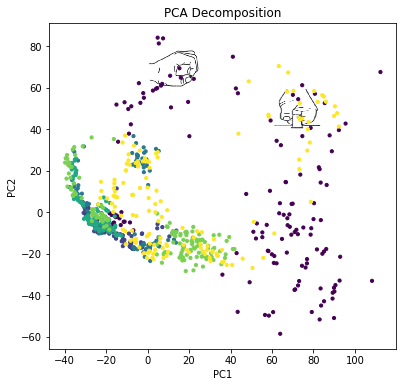

In [91]:
import matplotlib.image as mpimg
img1 = mpimg.imread('cylindrical.png') 
img2 = mpimg.imread('hook.png') 
img3 = mpimg.imread('lateral.png') 
img4 = mpimg.imread('palmar.png') 
img5 = mpimg.imread('spherical.png') 
img6 = mpimg.imread('tip.png') 

fig = plt.figure(figsize=(9,6))
plt.imshow(img1, extent=(0, 25, 60, 80))
plt.imshow(img2, extent=(60, 85, 40, 60))
plt.imshow(img3, extent=(0, 25, 60, 80))
plt.imshow(img4, extent=(0, 25, 60, 80))
plt.imshow(img5, extent=(0, 25, 60, 80))
plt.imshow(img6, extent=(0, 25, 60, 80))

ax = plt.scatter(df_iso[:,0], df_iso[:,1], s=10, c=col)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Decomposition")
plt.show()

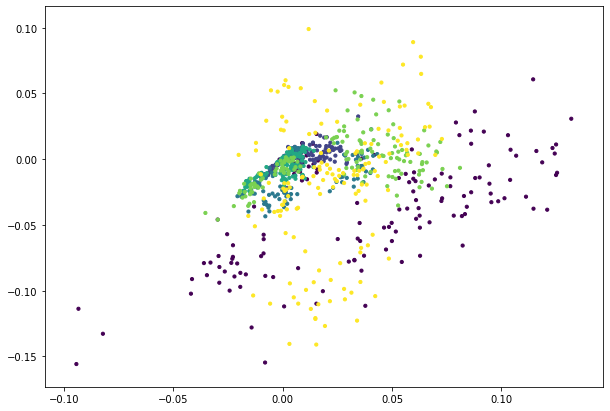

In [56]:
fig = plt.figure(figsize=(10,7))
ax = plt.scatter(df_pca[:,0], df_pca[:,1], s=10, c=col)

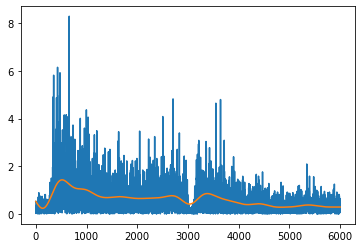

In [107]:
plt.plot(df_as_is.to_numpy()[0])
plt.plot(df_filter[0])

In [232]:
#SVC
parameters = {'degree':[2], 'gamma':['auto'], 'kernel':['rbf']}
svc = SVC()
svc_as_is = GridSearchCV(svc, parameters)
svc_as_is.fit(df_pca, df_labels)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'degree': [2], 'gamma': ['auto'], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [233]:
svc_as_is.cv_results_['mean_test_score']

array([0.26888889])

In [425]:
X_train, X_test, y_train, y_test = train_test_split(df_as_is, 
                                                    df_labels, 
                                                    test_size=0.2, 
                                                    random_state=12)

#clf = make_pipeline(StandardScaler(), SVC(C=0.001, degree=1))
#clf = make_pipeline(StandardScaler(), LogisticRegression(C=0.0001, max_iter=1000))
#clf = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(20,20,20,20), solver='lbfgs', max_iter=1000))


clf.fit(X_train, y_train)

svm_labels = clf.predict(X_test)

(svm_labels == y_test).value_counts()/len(X_test)

True     0.544444
False    0.455556
Name: label, dtype: float64

In [161]:
#Logistic
parameters = {'C':[10], 'max_iter': [1000], 'random_state':[0]}
log = LogisticRegression()
log_as_is = GridSearchCV(log, parameters)
log_as_is.fit(df_as_is, df_labels)

C:\Users\hayde\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [10], 'max_iter': [1000], 'random_state': [0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [162]:
log_as_is.cv_results_['mean_test_score']

array([0.29777778])

In [165]:
#Nerual Net
parameters = {'hidden_layer_sizes':[(20,20)], 'max_iter': [500], 'random_state':[0]}
n_net = MLPClassifier()
n_net_as_is = GridSearchCV(n_net, parameters)
n_net_as_is.fit(df_as_is, df_labels)

GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_gr

In [166]:
n_net_as_is.cv_results_['mean_test_score']

array([0.26])

In [132]:
#SVC
parameters = {'degree':[2], 'C':[0.001]}
svc = SVC()
svc_as_is = GridSearchCV(svc, parameters)
svc_as_is.fit(df_smoothed, df_labels)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001], 'degree': [2]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [133]:
svc_as_is.cv_results_['mean_test_score']

array([0.32555556])

In [94]:
#SVC
parameters = {'degree':(1,2,3), 'C':[0.1,1,10]}
svc = SVC()
svc_as_is = GridSearchCV(svc, parameters)
svc_as_is.fit(df_smoothed, df_labels)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'degree': (1, 2, 3)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [95]:
svc_as_is.cv_results_['mean_test_score']

array([0.31222222, 0.31222222, 0.31222222, 0.28      , 0.28      ,
       0.28      , 0.24222222, 0.24222222, 0.24222222])

In [96]:
#Logistic
parameters = {'C':[0.1,1,10], 'max_iter': [1000], 'random_state':[0]}
log = LogisticRegression()
log_as_is = GridSearchCV(log, parameters)
log_as_is.fit(df_smoothed, df_labels)

C:\Users\hayde\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\hayde\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'max_iter': [1000],
                         'random_state': [0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [97]:
log_as_is.cv_results_['mean_test_score']

array([0.29      , 0.27333333, 0.26777778])

In [98]:
#Nerual Net
parameters = {'hidden_layer_sizes':[(100,100)], 'max_iter': [500], 'random_state':[0]}
n_net = MLPClassifier()
n_net_as_is = GridSearchCV(n_net, parameters)
n_net_as_is.fit(df_smoothed, df_labels)

GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_gr

In [99]:
n_net_as_is.cv_results_['mean_test_score']

array([0.15777778])

In [108]:
#SVC
parameters = {'degree':(1,2,3), 'C':[0.1,1,10]}
svc = SVC()
svc_as_is = GridSearchCV(svc, parameters)
svc_as_is.fit(df_filter, df_labels)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'degree': (1, 2, 3)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [109]:
svc_as_is.cv_results_['mean_test_score']

array([0.3       , 0.3       , 0.3       , 0.27777778, 0.27777778,
       0.27777778, 0.25111111, 0.25111111, 0.25111111])

In [110]:
#Logistic
parameters = {'C':[0.1,1,10], 'max_iter': [1000], 'random_state':[0]}
log = LogisticRegression()
log_as_is = GridSearchCV(log, parameters)
log_as_is.fit(df_filter, df_labels)

C:\Users\hayde\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\hayde\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'max_iter': [1000],
                         'random_state': [0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [111]:
log_as_is.cv_results_['mean_test_score']

array([0.27222222, 0.27111111, 0.27888889])

In [112]:
#Nerual Net
parameters = {'hidden_layer_sizes':[(100,100)], 'max_iter': [500], 'random_state':[0]}
n_net = MLPClassifier()
n_net_as_is = GridSearchCV(n_net, parameters)
n_net_as_is.fit(df_filter, df_labels)

GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_gr

In [113]:
n_net_as_is.cv_results_['mean_test_score']

array([0.17222222])